In [1]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import gsw
from salishsea_tools.nc_tools import scDataset
import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
%matplotlib inline

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# 1. Bathymetry

In [2]:
idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
ideal = idealf['Bathymetry'][:]
realf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_for_agrif.nc')
real = realf['Bathymetry'][:]

imask = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/mesh_mask.nc')

(1500, -40)

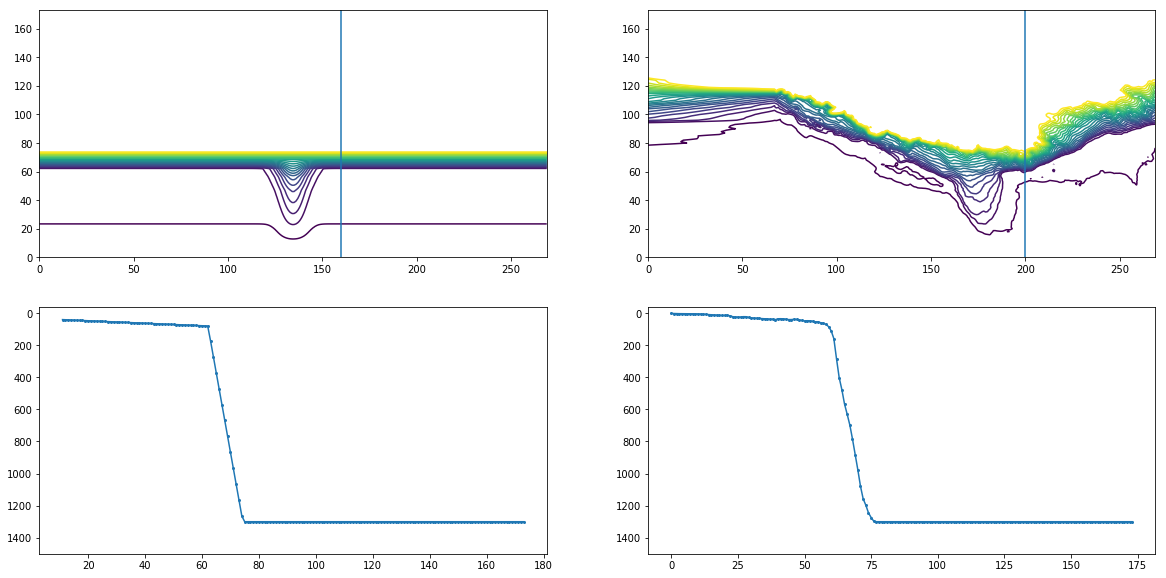

In [3]:
xs = np.arange(ideal.shape[-1])
ys = np.arange(ideal.shape[-2])
levels = np.arange(0, 1300, 50)

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20,10))
ax1.contour(xs, ys, ideal, levels=levels)
ax2.contour(xs, ys, real, levels=levels)

x_ideal = 160
x_real = 200

b_ideal = ideal[11:, x_ideal] # remove land
b_real = real[:, x_real]

ax1.axvline(x_ideal)
ax2.axvline(x_real)

ax3.plot(ys[11:], b_ideal, marker='o', ms=2) # remove land
ax4.plot(ys, b_real, marker='o', ms=2) # remove land

ax3.set_ylim([1500, -40])
ax4.set_ylim([1500, -40])

In [4]:
e2t = imask['e2t'][0, 11:, x_ideal] # remove land
y_cumsum = np.cumsum(e2t)

xdep = np.round((np.append(0, np.array(y_cumsum)))/1000,0)
depr = abs(np.round(np.append(b_ideal[0], b_ideal),0))

In [5]:
b_ideal.shape, y_cumsum.shape, xdep.shape, depr.shape

((163,), (163,), (164,), (164,))

# 2. N squared

In [6]:
tempf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/temperature/temperature_for_agrif.nc')
saltf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')

temp = np.array(tempf['votemper'][0, :, 0, 0])
salt = np.array(saltf['vosaline'][0, :, 0, 0])

In [7]:
z_t = np.array(imask['gdept_1d'][0, :-1])
z_w = np.array(imask['gdepw_1d'][0, :])

p = gsw.p_from_z(-1*z_w, 70.1)
N2, p_mid = gsw.Nsquared(salt, temp, p, 70.1)

z_increment = 100 #np.round(np.array(imask['e3w_1d'][0, :]),2)
z_interp = np.arange(0, 1400, z_increment)

f = interpolate.interp1d(z_t, N2, fill_value='extrapolate')
N2_interp = np.round(f(z_interp),12)

# 3. Alongshore velocity + bottom friction

In [8]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_U')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vozocrtx'][time_s:time_f,:,y,x]
        depth = ds.variables['depthu'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]

    #with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
    #    mask0 = dsM.variables['umask'][0,:,y,x]

    #mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))

    vel = vel0#np.ma.array(vel0, mask=1 - mask)
    
    return vel, depth, nav_lon, nav_lat

In [9]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = 'MCKNZ_1h_20170101_201701*'
meshmaskname = 'mesh_mask.nc'
time_s, time_f = 0, 24*4
uvel, depth, nav_lon, nav_lat = get_vels(dirname, fname, meshmaskname, time_s, time_f)
uvel_daily = np.nanmean(uvel, axis=0)

In [10]:
max_vel0 = np.nanmax(abs(uvel_daily))

try:
    inds = np.where(uvel_daily == max_vel0)
    print(inds)
    ind_z = inds[0][0]
    ind_y = inds[1][0]
    ind_x = inds[2][0]
except IndexError:
    inds = np.where(uvel_daily == -1*max_vel0)
    print(inds)
    ind_z = inds[0][0]
    ind_y = inds[1][0]
    ind_x = inds[2][0]

max_vel = uvel_daily[ind_z, ind_y, ind_x]
print(max_vel)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([0]), array([12]), array([126]))
-0.92695755


In [11]:
ind_z, ind_y, ind_x, max_vel, uvel_daily.shape

(0, 12, 126, -0.92695755, (80, 172, 268))

(1300, 0)

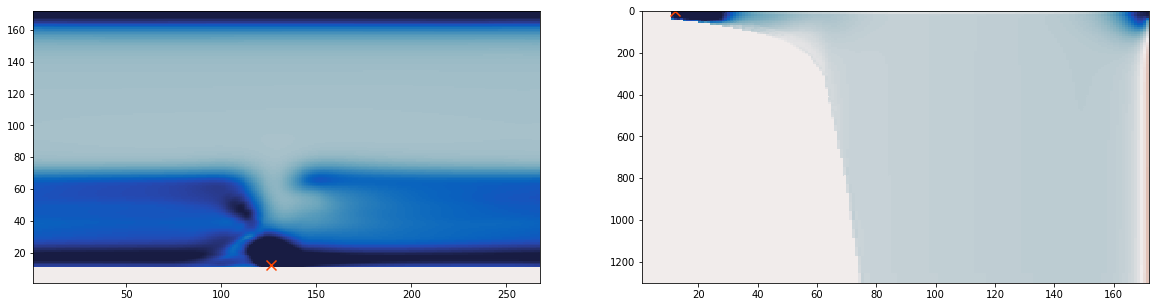

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.scatter(ind_x, ind_y, s=100, c='orangered', marker='x', zorder=2)
ax2.scatter(ind_y, ind_z, s=100, c='orangered', marker='x', zorder=2)

ax2.pcolormesh(ys[1:-1], z_w, uvel_daily[:, :, ind_x], vmin=-0.3, vmax=0.3, cmap=cmo.cm.balance)
ax1.pcolormesh(xs[1:-1], ys[1:-1], uvel_daily[ind_z, :, :], vmin=-0.3, vmax=0.3, cmap=cmo.cm.balance)

ax2.set_ylim([1300, 0])

In [13]:
# bottom friction
CDmin = 7.5e-3
CDmax = 2
bfr = np.round(np.mean(uvel)*100*CDmin,4)
bfr

-0.0243

# 4. Wave frequency

In [14]:
def get_w(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_W')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vovecrtz'][time_s:time_f,:,y,x]
        depth = ds.variables['depthw'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]

    #with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
    #    mask0 = dsM.variables['umask'][0,:,y,x]

    #mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))

    vel = vel0#np.ma.array(vel0, mask=1 - mask)
    
    return vel, depth, nav_lon, nav_lat

In [15]:
w_vel, depth, nav_lon, nav_lat = get_w(dirname, fname, meshmaskname, time_s, time_f+48)

w_vel_average = np.nanmean(w_vel, axis=1)
w_vel_average.shape

(144, 172, 268)

3.3e-06


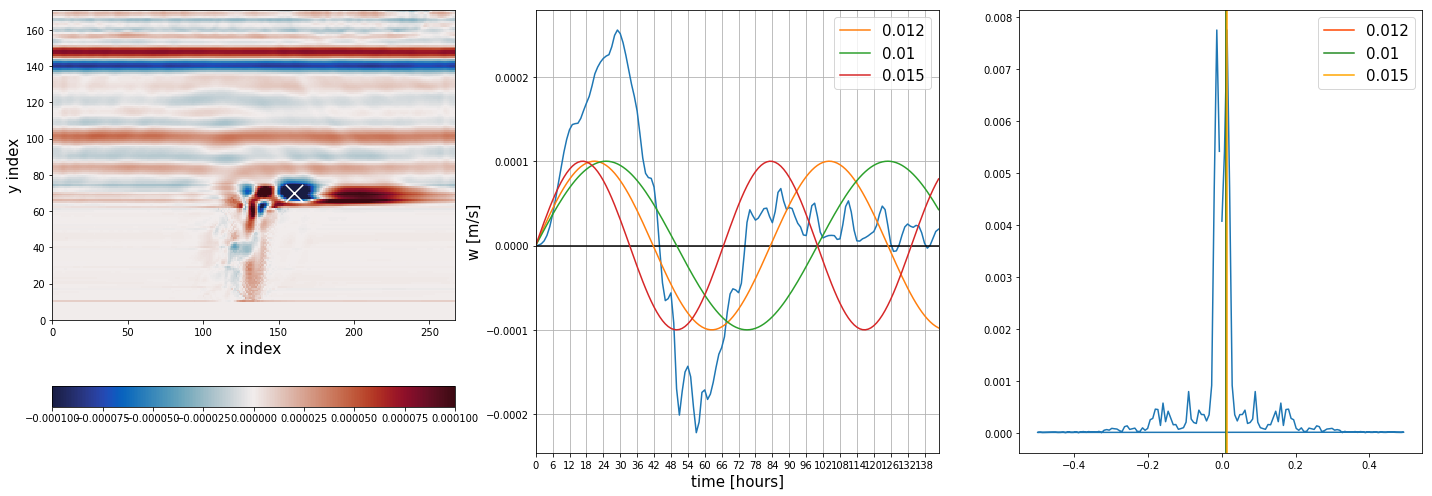

In [16]:
wave_x = 160
wave_y = 70
wave_t = 60

xs = np.arange(w_vel_average.shape[-1])
ys = np.arange(w_vel_average.shape[-2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
p=ax1.pcolormesh(xs, ys, w_vel_average[wave_t, :, :], cmap=cmo.cm.balance, vmin=-0.0001, vmax=0.0001)
ax1.scatter(wave_x, wave_y, c='w', s=300, marker='x')
fig.colorbar(p, ax=ax1, orientation='horizontal')
ax1.set_xlabel('x index', fontsize=15)
ax1.set_ylabel('y index', fontsize=15)

wave_w = w_vel_average[:, wave_y, wave_x]
ts = np.arange(w_vel_average.shape[0])
ax2.plot(ts, wave_w)
ax2.axhline(0,c='k')
ax2.xaxis.set_ticks(np.arange(ts[0], ts[-1], 6))
ax2.set_xlim([ts[0], ts[-1]])
ax2.set_xlabel('time [hours]', fontsize=15)
ax2.set_ylabel('w [m/s]', fontsize=15)
ax2.grid()

import numpy.fft as fft
spectrum = fft.fft(wave_w)
freq = fft.fftfreq(len(spectrum))
ax3.plot(freq, abs(spectrum))

freq_s = [0.012, 0.010, 0.015]
cs = ['orangered', 'forestgreen', 'orange']
for freq_this, c in zip (freq_s, cs):
    ax2.plot(ts, 0.0001*np.sin(2 * np.pi * freq_this * ts), label=str(freq_this))
    ax3.axvline(freq_this, label=str(freq_this), c=c)
ax2.legend(loc=1, fontsize=15)
ax3.legend(loc=1, fontsize=15)

freq_per_hour = freq_s[0]
freq_per_sec_fft = np.round(freq_per_hour/(60*60),7)
print(freq_per_sec_fft)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.06)

# 5. Wavenumber

In [17]:
e1t = np.nanmean(imask['e1t'][0, 1:-1, 1:-1], axis=0)
e2t = np.nanmean(imask['e2t'][0, 1:-1, 1:-1], axis=1)
e1t_sum = np.cumsum(e1t)
e2t_sum = np.cumsum(e2t)

136000 4.62e-07


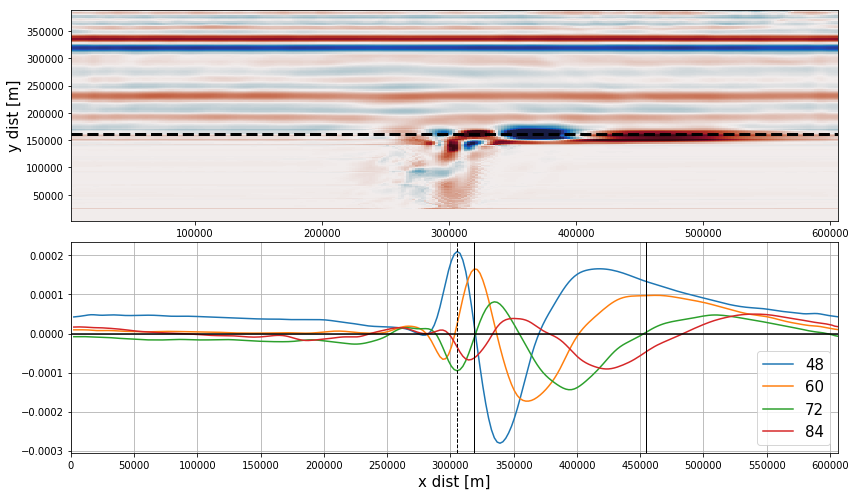

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 7))

p=ax1.pcolormesh(e1t_sum, e2t_sum, w_vel_average[wave_t, :, :], cmap=cmo.cm.balance, vmin=-0.0001, vmax=0.0001)
ax1.axhline(e2t_sum[wave_y], c='k',lw=3,linestyle='--')
ax1.set_xlabel('x dist [m]', fontsize=15)
ax1.set_ylabel('y dist [m]', fontsize=15)

for t_try in (12*np.arange(8))[4:]:
    ax2.plot(e1t_sum, w_vel_average[t_try, wave_y, :], label=str(t_try))
ax2.axhline(0,c='k')
ax2.set_xlim([0, e1t_sum[-1]])
ax2.xaxis.set_ticks(np.arange(0, e1t_sum[-1], 50000))
ax2.grid()
ax2.legend(loc=4, fontsize=15)
ax2.set_xlabel('x dist [m]', fontsize=15)

wlength_0=319*1000
wlength_f=455*1000
ax2.axvline(wlength_0, c='k',lw=1)
ax2.axvline(wlength_f, c='k',lw=1)

wlength_pre=305*1000
ax2.axvline(wlength_pre, c='k',lw=1,linestyle='--')

fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

wavelength = wlength_f-wlength_0
wavenumber = np.round((2*np.pi)/(wavelength*100),10)
print(wavelength, wavenumber)

In [19]:
#checking frequency
speed = (wlength_0-wlength_pre)/((60-48)*60*60)
freq_check = np.round(speed/wavelength,7)
freq_check

2.4e-06

# 7. Responses for program

In [28]:
wavenumber

4.62e-07

In [20]:
wavenumber_first = np.round(wavenumber*0.1,10)
numb_freq = 200
increment = np.round(wavenumber_first*0.1,10)

In [30]:
# from notebook looking at data output
k_test_1, f_test_1 = 1.888e-07, 1.0398498e-05
k_test_2, f_test_2 = 4.602e-07, 2.0012274e-05

In [31]:
print('How many total gridpoints do you want in the cross shelf direction? (nn)')
print(len(xdep))  
print('\nHow many total gridpoints do you want in the vertical? (mm)')
print(len(z_w))
print('\nFirst guess at frequency (rad/sec)? ')
print(freq_per_sec_fft,'(fft and '+str(freq_check)+' rough check)')
print('***** test 1 ', f_test_1)
print('***** test 2 ', f_test_2)
print('\nEnter 0 for a rigid lid, 1 for a free surface (del) ')
print(1)
print('\nEnter 0 for a closed x= 0 boundary, 1 for open (icbc) ')
print(0)
print('\nEnter 0 for a closed x =xmax boundary, 1 for an open (iobc)')
print(1)
print('\nEnter 1 for general frequency, wavenumber or 0 for long wave limit ')
print(1)
print('\nEnter the Coriolis parameter (f) (rad/sec) ')
print(0.0001368)
print('\nEnter the domain width (xmax) (km)')
width = int(np.round(y_cumsum[-1]/1000,0))
print(width)
print('\nEnter the nominal fractional accuracy for the solution (eps) ')
print(0.001)
print('\nEnter the number of frequencies to be computed (npts) ')
print(numb_freq)
print('***** tests ', 1)
print('\nEnter the first alongshore wavenumber to use (rlz) (rad/cm) ')
print(wavenumber_first,'(2pi/wavelength_cm )')
print('***** test 1 ', k_test_1)
print('***** test 2 ', k_test_2)
print('\nEnter the wavenumber increment to use after rlz (drl) (rad/cm)')
print(increment)
print('\nHow many distance, depth pairs will you provide (ndep >=1)')
print(len(b_ideal)+1)  
print('\nArray of offshore distances for depth values (xdep in km) (dimension ndep)')
print(xdep)
print('\nArray of depths corresponding to xdep (depr in m)') # positive!
print(depr)
print('\nNumber of distance, bottom friction pairs to read (nr) ')
print(2)
print('\nOffshore distances for bottom friction values (xr in km) ')
print('[0 '+str(width)+']')
print('\nArray of bottom friction values corresponding to xr (rr in cm/sec)')
print('[' + str(abs(bfr)) + ' ' + str(abs(bfr)) + '] (C_D_min * u_mean_cm)')
print('\nNumber of Nsquared values to read? (nnsq)')
print(len(N2_interp))
print('\nDepth increment for input of Nsquared values? (zr in m)')
print(z_increment)
print('\nExponential tail length for Nsquared extrapolation (alph in km')
print(2)
print('\nNsquared values starting at the surface (nsqr in rad^2/sec^2) (nnsq values)')
print(N2_interp)
print('\nInput peak value of mean alongshore flow (vzero: cm/sec)')
print(0, '(but max vel is '+str(np.round(max_vel*100,1))+')')
print('Input distance offshore to peak mean flow (km)')# 2.2
print('Input depth of peak mean flow (m)')#100
print('Downward exponential scale of mean flow? (m)')#1100
print('Upward exponential scale of mean flow? (m)')#100
print('Offshore exponential scale of mean flow? (km)')#40
print('Onshore exponential scale of mean flow? (km)')#100
print('Enter 1 for undisturbed Nsquared offshore, 0 for onshore 1')


How many total gridpoints do you want in the cross shelf direction? (nn)
164

How many total gridpoints do you want in the vertical? (mm)
80

First guess at frequency (rad/sec)? 
3.3e-06 (fft and 2.4e-06 rough check)
***** test 1  1.0398498e-05
***** test 2  2.0012274e-05

Enter 0 for a rigid lid, 1 for a free surface (del) 
1

Enter 0 for a closed x= 0 boundary, 1 for open (icbc) 
0

Enter 0 for a closed x =xmax boundary, 1 for an open (iobc)
1

Enter 1 for general frequency, wavenumber or 0 for long wave limit 
1

Enter the Coriolis parameter (f) (rad/sec) 
0.0001368

Enter the domain width (xmax) (km)
368

Enter the nominal fractional accuracy for the solution (eps) 
0.001

Enter the number of frequencies to be computed (npts) 
200
***** tests  1

Enter the first alongshore wavenumber to use (rlz) (rad/cm) 
4.62e-08 (2pi/wavelength_cm )
***** test 1  1.888e-07
***** test 2  4.602e-07

Enter the wavenumber increment to use after rlz (drl) (rad/cm)
4.6e-09

How many distance, depth pa

In [23]:
xdep.tolist()

[0.0,
 2.0,
 5.0,
 7.0,
 9.0,
 11.0,
 14.0,
 16.0,
 18.0,
 20.0,
 23.0,
 25.0,
 27.0,
 29.0,
 32.0,
 34.0,
 36.0,
 38.0,
 41.0,
 43.0,
 45.0,
 47.0,
 50.0,
 52.0,
 54.0,
 56.0,
 59.0,
 61.0,
 63.0,
 66.0,
 68.0,
 70.0,
 72.0,
 75.0,
 77.0,
 79.0,
 81.0,
 84.0,
 86.0,
 88.0,
 90.0,
 93.0,
 95.0,
 97.0,
 99.0,
 102.0,
 104.0,
 106.0,
 108.0,
 111.0,
 113.0,
 115.0,
 117.0,
 120.0,
 122.0,
 124.0,
 127.0,
 129.0,
 131.0,
 133.0,
 136.0,
 138.0,
 140.0,
 142.0,
 145.0,
 147.0,
 149.0,
 151.0,
 154.0,
 156.0,
 158.0,
 160.0,
 163.0,
 165.0,
 167.0,
 169.0,
 172.0,
 174.0,
 176.0,
 178.0,
 181.0,
 183.0,
 185.0,
 188.0,
 190.0,
 192.0,
 194.0,
 197.0,
 199.0,
 201.0,
 203.0,
 206.0,
 208.0,
 210.0,
 212.0,
 215.0,
 217.0,
 219.0,
 221.0,
 224.0,
 226.0,
 228.0,
 230.0,
 233.0,
 235.0,
 237.0,
 239.0,
 242.0,
 244.0,
 246.0,
 249.0,
 251.0,
 253.0,
 255.0,
 258.0,
 260.0,
 262.0,
 264.0,
 267.0,
 269.0,
 271.0,
 273.0,
 276.0,
 278.0,
 280.0,
 282.0,
 285.0,
 287.0,
 289.0,
 291.0,
 294.0,
 2

In [24]:
depr.tolist()

[40.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 44.0,
 45.0,
 46.0,
 47.0,
 47.0,
 48.0,
 49.0,
 50.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 54.0,
 55.0,
 56.0,
 57.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 61.0,
 62.0,
 63.0,
 64.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 68.0,
 69.0,
 70.0,
 71.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 79.0,
 80.0,
 172.0,
 272.0,
 371.0,
 470.0,
 570.0,
 669.0,
 768.0,
 868.0,
 967.0,
 1066.0,
 1166.0,
 1265.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,
 1300.0,

In [25]:
N2_interp.tolist()

[0.006176964391,
 0.000262144846,
 4.220017e-05,
 8.818209e-06,
 3.68712e-06,
 1.533871e-06,
 1.817461e-06,
 1.67956e-06,
 1.425485e-06,
 1.356658e-06,
 1.258287e-06,
 1.183834e-06,
 1.170308e-06,
 4.63724e-07]

In [26]:
print('wavenumber, wavenumber_first, numb_freq, increment', wavenumber, wavenumber_first, numb_freq, increment)

for i in range(numb_freq):
    wavenumber_next = np.round((i*increment)+wavenumber_first,10)
    print(i,wavenumber_next)

wavenumber, wavenumber_first, numb_freq, increment 4.62e-07 4.62e-08 200 4.6e-09
0 4.62e-08
1 5.08e-08
2 5.54e-08
3 6e-08
4 6.46e-08
5 6.92e-08
6 7.38e-08
7 7.84e-08
8 8.3e-08
9 8.76e-08
10 9.22e-08
11 9.68e-08
12 1.014e-07
13 1.06e-07
14 1.106e-07
15 1.152e-07
16 1.198e-07
17 1.244e-07
18 1.29e-07
19 1.336e-07
20 1.382e-07
21 1.428e-07
22 1.474e-07
23 1.52e-07
24 1.566e-07
25 1.612e-07
26 1.658e-07
27 1.704e-07
28 1.75e-07
29 1.796e-07
30 1.842e-07
31 1.888e-07
32 1.934e-07
33 1.98e-07
34 2.026e-07
35 2.072e-07
36 2.118e-07
37 2.164e-07
38 2.21e-07
39 2.256e-07
40 2.302e-07
41 2.348e-07
42 2.394e-07
43 2.44e-07
44 2.486e-07
45 2.532e-07
46 2.578e-07
47 2.624e-07
48 2.67e-07
49 2.716e-07
50 2.762e-07
51 2.808e-07
52 2.854e-07
53 2.9e-07
54 2.946e-07
55 2.992e-07
56 3.038e-07
57 3.084e-07
58 3.13e-07
59 3.176e-07
60 3.222e-07
61 3.268e-07
62 3.314e-07
63 3.36e-07
64 3.406e-07
65 3.452e-07
66 3.498e-07
67 3.544e-07
68 3.59e-07
69 3.636e-07
70 3.682e-07
71 3.728e-07
72 3.774e-07
73 3.82e-